# Somali Triage — 5‑Model Benchmark, Fine‑Tune (Group‑Based), and Somali Headers

This notebook:
1) Loads `triage.csv` (target: `Triage_Level_SO` in Somali),
2) Uses a **group-based holdout** split by symptom-presence pattern (`Has_*` columns),
3) Benchmarks **5 models** (LR, RF, XGB, KNN, SVC) and builds **Table 1** (Accuracy/Precision/Recall/F1/AUC) and **Table 2** (TP/FP/FN/TN),
4) Selects the best by **Macro‑F1** and **fine‑tunes** it using **GroupKFold** grid search,
5) Evaluates on held‑out test and saves artifacts in `artifacts/`,
6) Exports a copy of the dataset with **Somali column headers** for UI/next steps.

In [1]:
# %pip install -q scikit-learn==1.4.2 xgboost pandas numpy matplotlib joblib pyyaml

import os, json, yaml, joblib, ctypes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, label_binarize, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             multilabel_confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.base import clone
from xgboost import XGBClassifier  # <-- direct import (no detection)

# Optional: macOS OpenMP hint (harmless if not needed)
if os.uname().sysname == 'Darwin':
    p = '/opt/homebrew/opt/libomp/lib/libomp.dylib'
    if os.path.exists(p):
        os.environ['DYLD_LIBRARY_PATH'] = p + ':' + os.environ.get('DYLD_LIBRARY_PATH', '')
        try:
            ctypes.CDLL(p)
        except Exception:
            pass

ART_DIR = Path('artifacts'); ART_DIR.mkdir(exist_ok=True)

In [2]:
DATA_PATH = 'triage.csv'   # your dataset
MAP_PATH  = 'map.yml'      # optional token map
ART_DIR = Path('artifacts'); ART_DIR.mkdir(exist_ok=True)

assert os.path.exists(DATA_PATH), f'Missing data file: {DATA_PATH}'
print('Using data:', DATA_PATH)
print('Using map :', MAP_PATH if os.path.exists(MAP_PATH) else '(none)')

Using data: triage.csv
Using map : map.yml


In [3]:
def build_presence_groups(df: pd.DataFrame) -> pd.Series:
    pres_cols = [c for c in df.columns if c.startswith('Has_')]
    if not pres_cols:
        raise ValueError('No Has_* columns found to build presence groups.')
    return df[pres_cols].astype(str).agg('_'.join, axis=1)

def split_group_holdout(X, y, groups, seed=42):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))
    return X.iloc[tr_idx], X.iloc[te_idx], y.iloc[tr_idx], y.iloc[te_idx]

def make_preprocessor(cat_cols, num_cols):
    return ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ('num', 'passthrough', num_cols),
    ])

def plot_confusion(cm: np.ndarray, labels, out_path: Path, title: str):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha='center', va='center',
                     color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches='tight')
    plt.close()

In [4]:
df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]
print('Shape:', df.shape)
df.head(3)

Shape: (15000, 34)


,Case_ID,Triage_Level_SO,Tips_SO,Age_Group,Has_Fever,Has_Cough,Has_Headache,Has_Abdominal_Pain,Has_Fatigue,Has_Vomiting,...,Diarrhea,Fatigue_Severity,Fatigue_Duration_Level,Weight_Loss,Fever_With_Fatigue,Vomiting_Severity,Vomiting_Duration_Level,Blood_Vomit,Unable_To_Keep_Fluids,Red_Flag_Count
0,C000001,Xaalad fudud (Daryeel guri),"• Ku naso guriga, cab biyo badan, cun cunto fu...",qof weyn,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,C000002,Xaalad fudud (Daryeel guri),"• Ku naso guriga, cab biyo badan, cun cunto fu...",waayeel,0,0,0,0,1,0,...,NaN,fudud,aad u daran,haa,maya,NaN,NaN,NaN,NaN,0
2,C000003,Xaalad dhax dhaxaad eh (Bukaan socod),• Booqo xarun caafimaad ama farmashiye caafima...,qof weyn,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
TARGET = 'Triage_Level_SO'
DROP_COLS = [c for c in ['Case_ID', 'Tips_SO', 'Red_Flag_Count'] if c in df.columns]

X = df.drop(columns=[TARGET] + DROP_COLS, errors='ignore')

le = LabelEncoder()
y_all_enc = le.fit_transform(df[TARGET].astype(str))     # 0..K-1
labels_so  = le.classes_.tolist()                        # Somali names
labels_idx = list(range(len(labels_so)))
y_enc = pd.Series(y_all_enc, index=df.index, name='Triage_Level_SO_enc')

print('Features:', X.shape, '| Target (encoded):', y_enc.shape)

Features: (15000, 30) | Target (encoded): (15000,)


In [6]:
groups = build_presence_groups(df)
X_train, X_test, y_train_enc, y_test_enc = split_group_holdout(X, y_enc, groups, seed=42)
print('Train:', X_train.shape, ' Test:', X_test.shape)

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()
pre = make_preprocessor(cat_cols, num_cols)

Y_test_bin = label_binarize(y_test_enc, classes=labels_idx)

Train: (11413, 30)  Test: (3587, 30)


In [8]:
# === Benchmark 5 models -> Table 1 & Table 2 (warnings suppressed) ===
import warnings, logging
from sklearn.exceptions import ConvergenceWarning
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize

# Silence all common warning sources
warnings.filterwarnings("ignore")  # blanket
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
logging.getLogger("xgboost").setLevel(logging.CRITICAL)

def make_models():
    return {
        'LR':  LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced'),
        'RF':  RandomForestClassifier(
            n_estimators=300, max_depth=12, min_samples_leaf=2,
            class_weight='balanced', random_state=42, n_jobs=-1
        ),
        'KNN': KNeighborsClassifier(n_neighbors=15, weights='distance'),
        'SVC': SVC(C=2.0, kernel='rbf', probability=True, class_weight='balanced', random_state=42),
        'XGB': XGBClassifier(
            n_estimators=300, max_depth=5, learning_rate=0.1,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            eval_metric='mlogloss', random_state=42, n_jobs=-1,
            verbosity=0, use_label_encoder=False
        ),
    }

# Ensure binarized test labels for AUC (uses encoded labels already prepared)
Y_test_bin = label_binarize(y_test_enc, classes=labels_idx)

def fit_and_eval(name, estimator):
    est = clone(estimator)  # fresh copy
    pipe = Pipeline([('prep', pre), ('clf', est)])
    pipe.fit(X_train, y_train_enc)
    y_pred = pipe.predict(X_test)

    # Probabilities / decision scores for AUC
    proba = None
    clf = pipe.named_steps['clf']
    if hasattr(clf, 'predict_proba'):
        proba = pipe.predict_proba(X_test)
    elif hasattr(clf, 'decision_function'):
        dfc = pipe.decision_function(X_test)
        if dfc.ndim == 1:
            dfc = np.vstack([-dfc, dfc]).T
        proba = (dfc - dfc.min()) / (dfc.max() - dfc.min() + 1e-9)

    acc  = accuracy_score(y_test_enc, y_pred)
    prec = precision_score(y_test_enc, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_test_enc, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_test_enc, y_pred, average='macro', zero_division=0)

    auc = np.nan
    try:
        if proba is not None and len(labels_idx) > 1:
            auc = roc_auc_score(Y_test_bin, proba, multi_class='ovr', average='macro')
    except Exception:
        pass

    # TP/FP/FN/TN totals (micro) across classes
    mcm = multilabel_confusion_matrix(y_test_enc, y_pred, labels=labels_idx)
    tn = mcm[:, 0, 0].sum()
    fp = mcm[:, 0, 1].sum()
    fn = mcm[:, 1, 0].sum()
    tp = mcm[:, 1, 1].sum()

    return (
        {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc},
        {'Model': name, 'TP': int(tp), 'FP': int(fp), 'FN': int(fn), 'TN': int(tn)},
        pipe
    )

rows1, rows2, fitted = [], [], {}

# Fit/evaluate with warnings suppressed
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for name, est in make_models().items():
        m1, m2, pipe = fit_and_eval(name, est)
        rows1.append(m1); rows2.append(m2); fitted[name] = pipe

table1 = pd.DataFrame(rows1).set_index('Model').round(3)
table2 = pd.DataFrame(rows2).set_index('Model')

display(table1)
display(table2)

# Save tables (keep if you still want artifacts)
table1.to_csv(ART_DIR / 'Table1_model_metrics.csv')
table2.to_csv(ART_DIR / 'Table2_confusion_counts.csv')

# Pick best by Macro-F1 (ties -> higher Accuracy)
best_name = table1.sort_values(['F1','Accuracy'], ascending=False).index[0]
print('Best candidate by Macro-F1:', best_name)

,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
LR,0.921,0.930,0.927,0.926,0.988
RF,0.950,0.954,0.954,0.954,0.989
KNN,0.838,0.867,0.838,0.843,0.950
SVC,0.982,0.984,0.983,0.983,0.991
XGB,0.984,0.985,0.984,0.985,0.992


,TP,FP,FN,TN
Model,,,,
LR,3303,284,284,6890
RF,3409,178,178,6996
KNN,3006,581,581,6593
SVC,3521,66,66,7108
XGB,3528,59,59,7115


Best candidate by Macro-F1: XGB


In [9]:
def param_grid_for(model_name: str):
    if model_name == 'RF':
        return {'clf__n_estimators': [200,300,400],
                'clf__max_depth': [10,12,14],
                'clf__min_samples_leaf': [1,2,3],
                'clf__max_features': ['sqrt']}
    if model_name == 'LR':
        return {'clf__C': [0.5,1.0,2.0],
                'clf__solver': ['lbfgs'],
                'clf__max_iter': [1000,2000]}
    if model_name == 'KNN':
        return {'clf__n_neighbors': [7,11,15,19],
                'clf__weights': ['uniform','distance'],
                'clf__p': [1,2]}
    if model_name == 'SVC':
        return {'clf__C': [0.5,1.0,2.0],
                'clf__kernel': ['rbf'],
                'clf__gamma': ['scale','auto']}
    if model_name == 'XGB':
        return {'clf__n_estimators': [200,400],
                'clf__max_depth': [4,6],
                'clf__learning_rate': [0.05,0.1],
                'clf__subsample': [0.8,1.0],
                'clf__colsample_bytree': [0.8,1.0]}
    raise ValueError(f'No grid defined for {model_name}')

base_est = make_models()[best_name]
pipe = Pipeline([('prep', pre), ('clf', base_est)])

gkf = GroupKFold(n_splits=5)
train_groups = build_presence_groups(df.loc[X_train.index])

grid = GridSearchCV(pipe,
                    param_grid_for(best_name),
                    scoring='f1_macro',
                    cv=gkf,
                    n_jobs=-1,
                    verbose=0)

grid.fit(X_train, y_train_enc, **{'groups': train_groups})
best_model = grid.best_estimator_
print('Best params:', grid.best_params_)

Best params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__n_estimators': 200, 'clf__subsample': 0.8}


In [10]:
y_pred_enc = best_model.predict(X_test)
acc = accuracy_score(y_test_enc, y_pred_enc)
macro_f1 = f1_score(y_test_enc, y_pred_enc, average='macro')

cm = confusion_matrix(y_test_enc, y_pred_enc, labels=labels_idx)
print(f'Accuracy: {acc:.3f} | Macro-F1: {macro_f1:.3f}')

pd.DataFrame(cm,
             index=[f'Actual_{s}' for s in labels_so],
             columns=[f'Pred_{s}' for s in labels_so])

Accuracy: 0.984 | Macro-F1: 0.985


,Pred_Xaalad deg deg ah,Pred_Xaalad dhax dhaxaad eh (Bukaan socod),Pred_Xaalad fudud (Daryeel guri)
Actual_Xaalad deg deg ah,1029,0,0
Actual_Xaalad dhax dhaxaad eh (Bukaan socod),0,1299,0
Actual_Xaalad fudud (Daryeel guri),0,58,1201


In [11]:
(ART_DIR / 'best_model_metrics.json').write_text(
    json.dumps({'best_model': str(best_name),
                'accuracy': float(acc),
                'macro_f1': float(macro_f1),
                'best_params': grid.best_params_}, indent=2, ensure_ascii=False),
    encoding='utf-8'
)

pd.DataFrame(classification_report(
    y_test_enc, y_pred_enc, target_names=labels_so, output_dict=True, zero_division=0)
).transpose().to_csv(ART_DIR / 'best_model_classification_report.csv')

plot_confusion(cm, labels_so, ART_DIR / 'best_model_confusion_matrix.png',
               title=f'Confusion Matrix — {best_name} (tuned)')
pd.DataFrame(cm,
             index=[f'Actual_{s}' for s in labels_so],
             columns=[f'Pred_{s}' for s in labels_so]
).to_csv(ART_DIR / 'best_model_confusion_matrix.csv')

joblib.dump({
    'pipeline': best_model,
    'label_encoder': le,
    'labels_so': labels_so,
    'cat_cols': cat_cols,
    'num_cols': num_cols,
    'best_name': best_name,
    'best_params': grid.best_params_
}, ART_DIR / 'triage_best.pkl')

print('Saved artifacts to:', ART_DIR.resolve())

Saved artifacts to: /Users/momustafahmed/Library/CloudStorage/OneDrive-ChulalongkornUniversity/1. Manuscripts/1. 2025/8. August/Medical Triage/artifacts


In [20]:
# ==== End-user preview: random case from the last 5000 (Somali, simple output, one-sentence advice) ====
import numpy as np, pandas as pd

# Resolve fitted pipeline
pipe = None
for cand in ("best_pipe", "best_model"):
    if cand in globals():
        pipe = globals()[cand]
        break
if pipe is None:
    raise RuntimeError("Fadlan marka hore tababar moodelka (best_pipe ama best_model).")

# Helpers
def decode_label(z):
    if 'le' in globals():
        try:
            if isinstance(z, (int, np.integer)):
                return le.inverse_transform([z])[0]
        except Exception:
            pass
    if 'label_encoder' in globals():
        try:
            if isinstance(z, (int, np.integer)):
                return label_encoder.inverse_transform([z])[0]
        except Exception:
            pass
    return str(z)

def to_one_statement(s: str) -> str:
    s = " ".join(str(s).split())
    s = s.replace("•", ", ")
    s = s.replace(". ", ", ")
    while ".." in s:
        s = s.replace("..", ".")
    if s and not s.endswith("."):
        s += "."
    return s

# Default Somali advice (each as ONE sentence)
triage_tips = {
    "Xaalad fudud (Daryeel guri)":
        "Ku naso guriga, cab biyo badan, cun cunto fudud, qaado xanuun baabi'iye ama qandho dajiye haddii aad u baahantahay, la soco calaamadahaaga 24 saac, haddii ay kasii daraan la xiriir xarun caafimaad.",
    "Xaalad dhax dhaxaad eh (Bukaan socod)":
        "Booqo xarun caafimaad 24 saacadood gudahood si lagu qiimeeyo, qaado warqadaha daawooyinkii hore haddii ay jiraan, cab biyo badan.",
    "Xaalad dhax dhaxaad ah (Bukaan socod)":
        "Booqo xarun caafimaad 24 saacadood gudahood si lagu qiimeeyo, qaado warqadaha daawooyinkii hore haddii ay jiraan, cab biyo badan.",
    "Xaalad deg deg ah":
        "Si deg deg ah u gaar isbitaalka, ha isku dayin daaweynta guriga, haddii ay suurtagal tahay raac qof kugu weheliya, qaado warqadaha daawooyinkii hore haddii ay jiraan.",
}

# Pick a random row from the last 5000 of X_test
if 'X_test' not in globals() or len(X_test) == 0:
    raise RuntimeError("X_test lama helin. Fadlan socodsii unugyada kala-qaybinta iyo tababarka.")

start = max(0, len(X_test) - 5000)
X_tail = X_test.iloc[start:]

rng = np.random.default_rng()
row_in_tail = int(rng.integers(0, len(X_tail)))
x_row = X_tail.iloc[[row_in_tail]]
orig_idx = x_row.index[0]

# Predict + advice
pred_raw = pipe.predict(x_row)[0]
pred_so  = decode_label(pred_raw)

advice = None
if 'df' in globals() and 'Tips_SO' in df.columns:
    try:
        advice = df.loc[orig_idx, 'Tips_SO']
        if pd.isna(advice):
            advice = None
    except Exception:
        advice = None
if advice is None:
    advice = triage_tips.get(pred_so, "La-talin lama heli karo.")

# Force one-sentence output
advice = to_one_statement(advice)

print(f"Xaaladdaada: {pred_so}.")
print(f"Talo: {advice}")
print("Farriin gaar ah: Tan waa qiimeyn guud oo kaa caawinaysa inaad fahanto xaaladdaada iyo waxa xiga. Haddii aad ka welwelsan tahay xaaladdaada, la xiriir dhakhtar.")

Xaaladdaada: Xaalad deg deg ah.
Talo: ,  Si deg deg ah u gaar isbitaalka; ha isku dayin daaweynta guriga, ,  Haddii ay suurtagal tahay, raac qof kugu weheliya safarka, ,  Qaado warqadaha daawooyinkii hore iyo xog hore ee caafimaad haddii ay jiraan.
Farriin gaar ah: Tan waa qiimeyn guud oo kaa caawinaysa inaad fahanto xaaladdaada iyo waxa xiga. Haddii aad ka welwelsan tahay xaaladdaada, la xiriir dhakhtar.


## Somali column headers (alias dataset)
This creates a dataset copy with **Somali column headers** for your UI. Training above continues to use English headers for stability.

In [13]:
so_headers = {
    'Case_ID': 'ID',
    'Triage_Level_SO': 'Xaaladda',
    'Tips_SO': 'Talooyin',
    'Has_Fever': 'Qandho',
    'Fever_Level': 'Heerka_Qandhada',
    'Fever_Duration_Level': 'Mudada_Qandhada',
    'Chills': 'Qarqaryo',
    'Has_Cough': 'Qufac',
    'Cough_Type': 'Nuuca_Qufaca',
    'Cough_Duration_Level': 'Mudada_Qufaca',
    'Blood_Cough': 'Qufac_dhiig',
    'Breath_Difficulty': 'Neef_qabasho',
    'Has_Headache': 'Madax_xanuun',
    'Headache_Severity': 'Heerka_Madax_xanuunka',
    'Headache_Duration_Level': 'Mudada_Madax_xanuunka',
    'Photophobia': 'Iftiinka_dhibaayo',
    'Neck_Stiffness': 'Qoor_adeeeg',
    'Has_Abdominal_Pain': 'Calool_xanuun',
    'Pain_Location': 'Goobta_Xanuunka_Caloosha',
    'Pain_Duration_Level': 'Mudada_Xanuunka_Caloosha',
    'Nausea': 'Lallabbo',
    'Diarrhea': 'Shuban',
    'Has_Fatigue': 'Daal',
    'Fatigue_Severity': 'Heerka_Daalka',
    'Fatigue_Duration_Level': 'Mudada_Daalka',
    'Weight_Loss': 'Miisaan_Dhimis',
    'Fever_With_Fatigue': 'Qandho_la_Socota_Daal',
    'Has_Vomiting': 'Matag',
    'Vomiting_Severity': 'Heerka_Mataga',
    'Vomiting_Duration_Level': 'Mudada_Mataga',
    'Blood_Vomit': 'Matag_dhiig',
    'Unable_To_Keep_Fluids': 'Aan_ceshan_karin_dareeraha',
    'Age_Group': "Da'da",
    'Red_Flag_Count': 'Tirada_Calaamadaha_Khatarta_ah',
}
existing_map = {en: so for en, so in so_headers.items() if en in df.columns}
df_so = df.rename(columns=existing_map)
df_so.to_csv('triage_SO_headers.csv', index=False)
with open('column_headers_map_so.yml', 'w', encoding='utf-8') as f:
    yaml.safe_dump(existing_map, f, allow_unicode=True, sort_keys=False)

print('Saved:', Path('triage_SO_headers.csv').resolve())
print('Saved:', Path('column_headers_map_so.yml').resolve())

Saved: /Users/momustafahmed/Library/CloudStorage/OneDrive-ChulalongkornUniversity/1. Manuscripts/1. 2025/8. August/Medical Triage/triage_SO_headers.csv
Saved: /Users/momustafahmed/Library/CloudStorage/OneDrive-ChulalongkornUniversity/1. Manuscripts/1. 2025/8. August/Medical Triage/column_headers_map_so.yml


### Figures

 Imports, helpers, and paths
 

In [21]:
# ==== Cell 0: Imports, helpers, and paths ====
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.preprocessing import label_binarize
from sklearn.base import clone

# folder to save figures
FIG_DIR = Path("figs"); FIG_DIR.mkdir(exist_ok=True)

def get_proba(pipe, X):
    """Return n_samples x n_classes matrix of probabilities or scaled decision scores."""
    clf = pipe.named_steps.get('clf', pipe)
    if hasattr(clf, "predict_proba"):
        p = pipe.predict_proba(X)
        # Some binary estimators return shape (n,); make it (n, 2)
        if p.ndim == 1:
            p = np.vstack([1-p, p]).T
        return p
    elif hasattr(clf, "decision_function"):
        s = pipe.decision_function(X)
        if s.ndim == 1:          # binary -> make 2 columns
            s = np.vstack([-s, s]).T
        # scale to [0,1] per column to act like "probabilities"
        s_min, s_max = s.min(axis=0, keepdims=True), s.max(axis=0, keepdims=True)
        p = (s - s_min) / (s_max - s_min + 1e-9)
        # small normalization to sum to 1
        p = p / (p.sum(axis=1, keepdims=True) + 1e-9)
        return p
    else:
        # last resort: one-hot of predictions
        y_hat = pipe.predict(X)
        n = len(y_hat); k = len(np.unique(y_hat))
        out = np.zeros((n, k)); out[np.arange(n), y_hat] = 1.0
        return out

def micro_roc(y_true_enc, proba, classes):
    """Compute micro-average ROC points and AUC."""
    Y_bin = label_binarize(y_true_enc, classes=classes)
    fpr, tpr, _ = roc_curve(Y_bin.ravel(), proba.ravel())
    auc = roc_auc_score(Y_bin, proba, multi_class="ovr", average="macro")
    return fpr, tpr, auc

def save_show(fig, path):
    path = FIG_DIR / path
    fig.savefig(path, bbox_inches="tight", dpi=300)
    print("Saved:", path.resolve())
    plt.show()

Rebuild metrics table



In [22]:
# ==== Cell 1 (robust, no mixed label types): build metrics across models ====
import numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

rows = []
for name, pipe in fitted.items():
    clf   = pipe.named_steps.get("clf", pipe)
    y_hat = pipe.predict(X_test)

    # use encoded y if available; else fall back to y_test
    y_true = y_test_enc if "y_test_enc" in globals() else y_test

    # make y_hat live in the same label space as y_true
    y_true_is_str = np.array(y_true).dtype.kind in "OUS"
    y_hat_is_str  = np.array(y_hat).dtype.kind in "OUS"

    if not y_true_is_str and y_hat_is_str:
        # y_true are ints, y_hat are str -> map strings -> ints via clf.classes_
        classes = list(getattr(clf, "classes_", sorted(np.unique(y_hat))))
        to_int  = {c: i for i, c in enumerate(classes)}
        y_hat   = pd.Series(y_hat).map(to_int).to_numpy()
    elif y_true_is_str and not y_hat_is_str:
        # y_true are str, y_hat are ints -> map ints -> strings via clf.classes_
        classes = list(getattr(clf, "classes_", sorted(np.unique(y_hat))))
        to_str  = {i: c for i, c in enumerate(classes)}
        y_hat   = pd.Series(y_hat).map(to_str).to_numpy()

    # probabilities for AUC (handles predict_proba or decision_function)
    prob = get_proba(pipe, X_test)

    acc  = accuracy_score(y_true, y_hat)
    prec = precision_score(y_true, y_hat, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_hat, average="macro", zero_division=0)
    f1   = f1_score(y_true, y_hat, average="macro", zero_division=0)

    auc = np.nan
    try:
        classes = list(getattr(clf, "classes_", sorted(np.unique(y_hat))))
        Yb = label_binarize(y_true, classes=classes)
        if prob is not None:
            # align prob columns to classes length
            if prob.shape[1] < len(classes):
                pad = np.zeros((prob.shape[0], len(classes) - prob.shape[1]))
                prob = np.hstack([prob, pad])
            elif prob.shape[1] > len(classes):
                prob = prob[:, :len(classes)]
            auc = roc_auc_score(Yb, prob, multi_class="ovr", average="macro")
    except Exception:
        pass

    rows.append({"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc})

metrics_df = pd.DataFrame(rows).set_index("Model").round(3)
display(metrics_df)

# Pick best by Macro-F1 (ties -> higher Accuracy)
best_name = metrics_df.sort_values(["F1", "Accuracy"], ascending=False).index[0]
print("Best candidate by Macro-F1:", best_name)

,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
LR,0.921,0.930,0.927,0.926,0.988
RF,0.950,0.954,0.954,0.954,0.989
KNN,0.838,0.867,0.838,0.843,0.950
SVC,0.982,0.984,0.983,0.983,0.991
XGB,0.984,0.985,0.984,0.985,0.992


Best candidate by Macro-F1: XGB


 Metrics bar chart
 

Saved: /Users/momustafahmed/Library/CloudStorage/OneDrive-ChulalongkornUniversity/1. Manuscripts/1. 2025/8. August/Medical Triage/figs/fig_metrics_bar.png


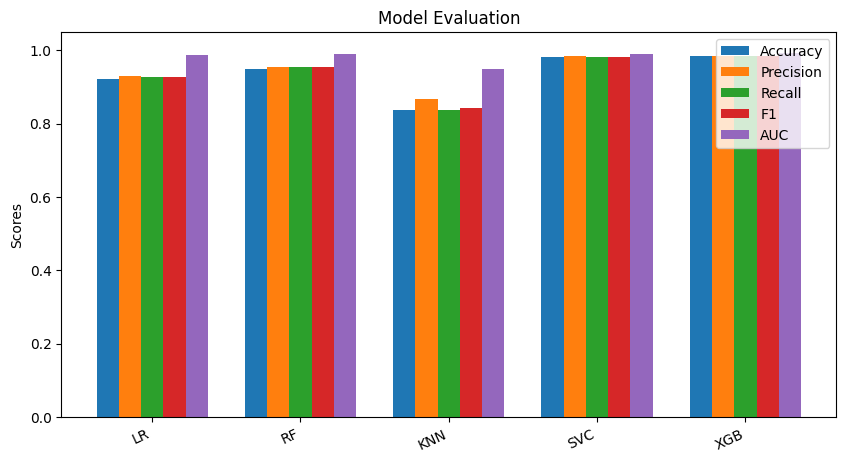

In [23]:
# ==== Cell 2: Metrics bar chart ====
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

FIG_DIR = Path("figs"); FIG_DIR.mkdir(exist_ok=True)

cols = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
M = metrics_df[cols]

x = np.arange(len(M.index))
w = 0.15

fig, ax = plt.subplots(figsize=(10, 5))
for i, c in enumerate(cols):
    ax.bar(x + (i - 2)*w, M[c].values, width=w, label=c)

ax.set_xticks(x)
ax.set_xticklabels(M.index, rotation=25, ha="right")
ax.set_ylim(0, 1.05)
ax.set_ylabel("Scores")
ax.set_title("Model Evaluation")
ax.legend()

p = FIG_DIR / "fig_metrics_bar.png"
fig.savefig(p, bbox_inches="tight", dpi=300)
print("Saved:", p.resolve())
plt.show()

ROC curves (micro-average) for all models

Saved: /Users/momustafahmed/Library/CloudStorage/OneDrive-ChulalongkornUniversity/1. Manuscripts/1. 2025/8. August/Medical Triage/figs/fig_roc_all_models.png


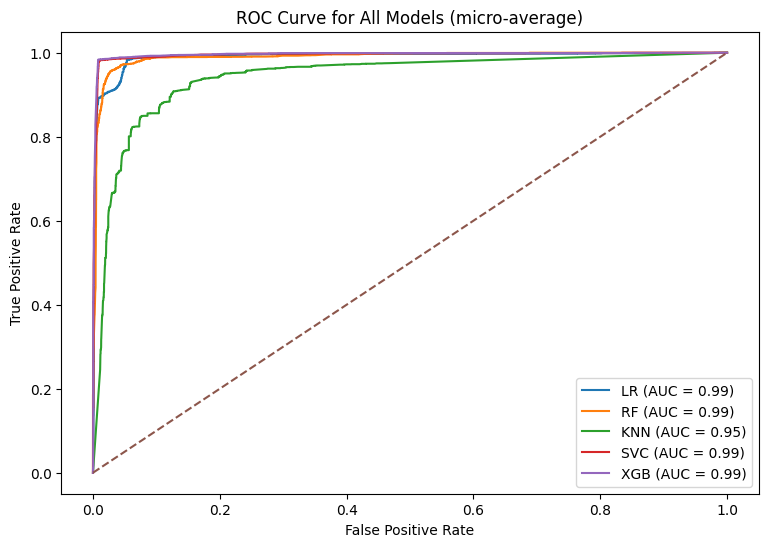

In [30]:
# ==== Cell 3: ROC curves (micro-average) for all models ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score

def _align_truth_for_model(y_true, y_true_enc, clf):
    classes = list(getattr(clf, "classes_", []))
    # if model classes are numeric and we have encoded truth, use encoded
    if len(classes) > 0 and np.array(classes).dtype.kind in "iuf" and ("y_test_enc" in globals()):
        y_use = y_true_enc
        classes_use = sorted(np.unique(y_use))
    else:
        y_use = y_true
        classes_use = list(getattr(clf, "classes_", sorted(np.unique(y_use))))
    return np.asarray(y_use), list(classes_use)

def _proba(pipe, X):
    clf = pipe.named_steps.get("clf", pipe)
    if hasattr(clf, "predict_proba"):
        p = pipe.predict_proba(X)
        if p.ndim == 1:
            p = np.vstack([1 - p, p]).T
        return p
    elif hasattr(clf, "decision_function"):
        s = pipe.decision_function(X)
        if s.ndim == 1:
            s = np.vstack([-s, s]).T
        s_min, s_max = s.min(axis=0, keepdims=True), s.max(axis=0, keepdims=True)
        p = (s - s_min) / (s_max - s_min + 1e-9)
        p = p / (p.sum(axis=1, keepdims=True) + 1e-9)
        return p
    else:
        y_hat = pipe.predict(X)
        k = len(np.unique(y_hat))
        out = np.zeros((len(y_hat), k)); out[np.arange(len(y_hat)), y_hat] = 1.0
        return out

fig, ax = plt.subplots(figsize=(9, 6))
for name, pipe in fitted.items():
    clf = pipe.named_steps.get("clf", pipe)
    # Always use defined truth; prefer encoded if available
    y_true_defined = y_test_enc if "y_test_enc" in globals() else None
    if y_true_defined is None:
        raise RuntimeError("y_test_enc not found; please run earlier training cells.")
    y_use, classes_use = _align_truth_for_model(y_true_defined, y_true_defined, clf)
    P = _proba(pipe, X_test)
    # pad/trim proba to match classes
    k = len(classes_use)
    if P.shape[1] < k:
        P = np.hstack([P, np.zeros((P.shape[0], k - P.shape[1]))])
    elif P.shape[1] > k:
        P = P[:, :k]

    Yb = label_binarize(y_use, classes=classes_use)
    fpr, tpr, _ = roc_curve(Yb.ravel(), P.ravel())
    auc = roc_auc_score(Yb, P, multi_class="ovr", average="macro")
    ax.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve for All Models (micro-average)")
ax.legend(loc="lower right")

p = FIG_DIR / "fig_roc_all_models.png"
fig.savefig(p, bbox_inches="tight", dpi=300)
print("Saved:", p.resolve())
plt.show()

Confusion matrix for best model

Saved: /Users/momustafahmed/Library/CloudStorage/OneDrive-ChulalongkornUniversity/1. Manuscripts/1. 2025/8. August/Medical Triage/figs/fig_confusion_matrix_best.png


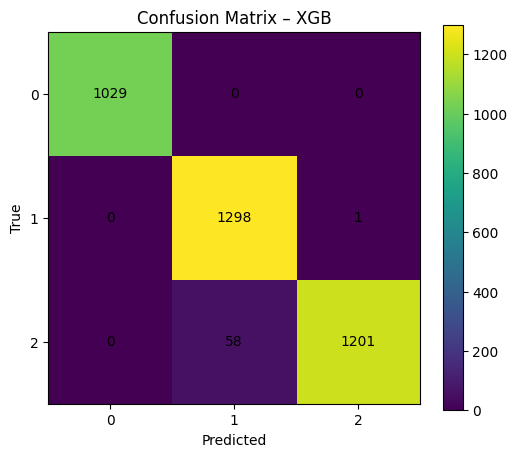

In [25]:
# ==== Cell 4: Confusion matrix for chosen/best model ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

best_name = metrics_df.sort_values(["F1", "Accuracy"], ascending=False).index[0]
best_pipe = fitted[best_name]
clf = best_pipe.named_steps.get("clf", best_pipe)

# align truth to the model
if hasattr(clf, "classes_") and np.array(clf.classes_).dtype.kind in "iuf" and ("y_test_enc" in globals()):
    y_true_use = y_test_enc
    tick_labels = sorted(np.unique(y_true_use))
else:
    y_true_use = y_test
    tick_labels = list(getattr(clf, "classes_", sorted(np.unique(y_true_use))))

y_pred = best_pipe.predict(X_test)
cm = confusion_matrix(y_true_use, y_pred, labels=tick_labels)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i, j]), ha="center", va="center")

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title(f"Confusion Matrix – {best_name}")
ax.set_xticks(range(len(tick_labels))); ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels, rotation=0); ax.set_yticklabels(tick_labels)
fig.colorbar(im, ax=ax)

p = FIG_DIR / "fig_confusion_matrix_best.png"
fig.savefig(p, bbox_inches="tight", dpi=300)
print("Saved:", p.resolve())
plt.show()

SHAP beeswarm (fallback to permutation importance)

PermutationExplainer explainer: 501it [00:11,  5.76it/s]                         



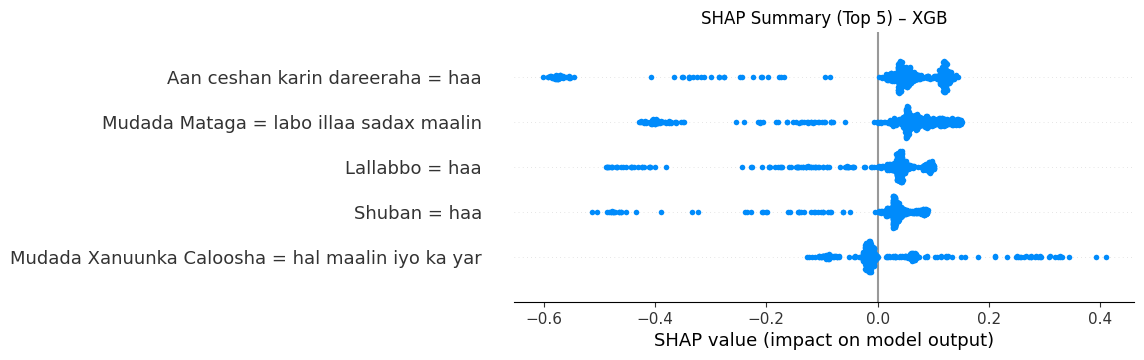

Saved: /Users/momustafahmed/Library/CloudStorage/OneDrive-ChulalongkornUniversity/1. Manuscripts/1. 2025/8. August/Medical Triage/figs/fig_shap_summary_top5_SO.png


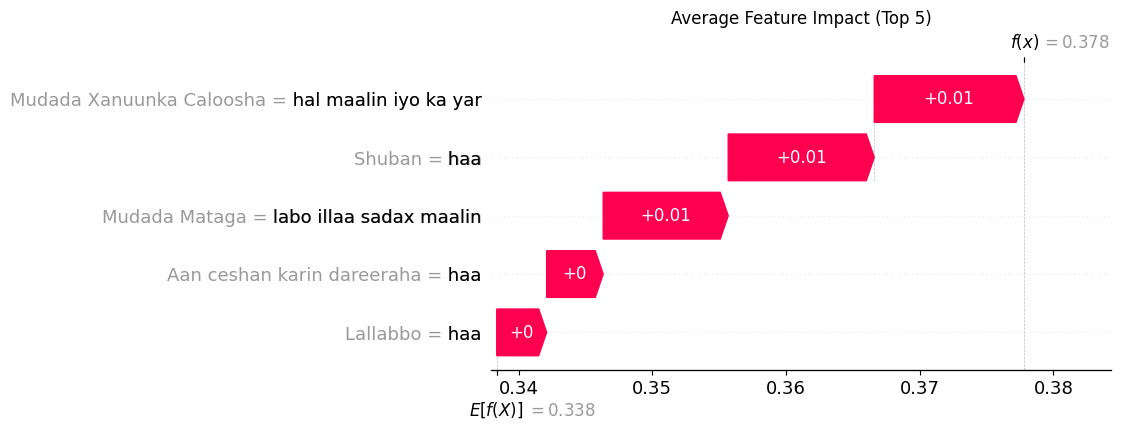

Saved: /Users/momustafahmed/Library/CloudStorage/OneDrive-ChulalongkornUniversity/1. Manuscripts/1. 2025/8. August/Medical Triage/figs/fig_shap_waterfall_avg_top5_SO.png


In [42]:
# ==== SHAP Beeswarm & Averaged Waterfall (Top 5, Somali labels) ====
import numpy as np, pandas as pd, shap, matplotlib.pyplot as plt
from pathlib import Path

FIG_DIR = Path("figs"); FIG_DIR.mkdir(exist_ok=True)

# Resolve best pipeline and classifier
best_name = metrics_df.sort_values(["F1", "Accuracy"], ascending=False).index[0]
best_pipe = fitted[best_name]
pre = best_pipe.named_steps.get("prep")
clf = best_pipe.named_steps.get("clf", best_pipe)

# Build explanation data in raw space and transform to numeric features
X_explain = X_test.copy()
Z_explain = pre.transform(X_explain) if pre is not None else X_explain.to_numpy()

# Get transformed feature names (fallback to positional)
feat_names = None
try:
    if pre is not None and hasattr(pre, "get_feature_names_out"):
        feat_names = list(pre.get_feature_names_out())
except Exception:
    feat_names = None
if feat_names is None:
    feat_names = [f"f{i}" for i in range(Z_explain.shape[1])]

# Mapping for duration tokens -> Somali phrases
DUR_DISPLAY = {
    "fudud": "hal maalin iyo ka yar",
    "dhexdhexaad": "labo illaa sadax maalin",
    "dhexdhexaad ah": "labo illaa sadax maalin",
    "aad u daran": "sadax maalin iyo ka badan",
}

# Somali display names for transformed features
def to_somali_display(n: str) -> str:
    # Strip transformer prefix like 'cat__' or 'num__'
    raw = n.split("__", 1)[-1]
    base, val = raw, None
    # If this is a one-hot feature, separate base and category using last underscore
    if "_" in raw:
        b, s = raw.rsplit("_", 1)
        base, val = (b, s)
    # Map base column to Somali if available
    som_base = existing_map.get(base, base) if 'existing_map' in globals() else base
    som_base = som_base.replace("_", " ")
    if val is None:
        return som_base
    # Category token may already be Somali; prettify and map if duration
    val_clean = val.replace("_", " ")
    if "Duration_Level" in base:
        key = val_clean.lower()
        val_clean = DUR_DISPLAY.get(key, val_clean)
    return f"{som_base} = {val_clean}"

feat_names_display = [to_somali_display(n) for n in feat_names]

# Optional: subsample for speed
rng = np.random.RandomState(42)
m = min(500, Z_explain.shape[0])
rows = rng.choice(Z_explain.shape[0], m, replace=False)

# Background in transformed (numeric) space
k_bg = min(200, max(50, Z_explain.shape[0] // 5))
Z_bg = Z_explain[rng.choice(Z_explain.shape[0], k_bg, replace=False)]

# Model function on transformed features
def _score_numeric(Z: np.ndarray) -> np.ndarray:
    if hasattr(clf, "predict_proba"):
        p = clf.predict_proba(Z)
        if p.ndim == 1:
            p = np.vstack([1 - p, p]).T
        return p
    if hasattr(clf, "decision_function"):
        s = clf.decision_function(Z)
        if s.ndim == 1:
            s = np.vstack([-s, s]).T
        s_min, s_max = s.min(axis=0, keepdims=True), s.max(axis=0, keepdims=True)
        p = (s - s_min) / (s_max - s_min + 1e-9)
        p = p / (p.sum(axis=1, keepdims=True) + 1e-9)
        return p
    y_hat = clf.predict(Z)
    classes = list(getattr(clf, "classes_", sorted(np.unique(y_hat))))
    to_idx = {c: i for i, c in enumerate(classes)}
    y_idx = np.vectorize(lambda v: to_idx.get(v, 0))(y_hat)
    out = np.zeros((len(y_idx), len(classes)))
    out[np.arange(len(y_idx)), y_idx] = 1.0
    return out

# Use a permutation-based explainer with numeric arrays
explainer = shap.Explainer(_score_numeric, Z_bg)
sv_all = explainer(Z_explain[rows])


def to_2d_explanation(sv, feature_names, strategy="max_class"):
    """
    Make SHAP 2D (n_samples, n_features) for beeswarm.
    Handles (n,F), (n,C,F), (n,F,C), or list-of-class Explanations.
    """
    # Case 1: list of per-class Explanations
    if getattr(sv, "values", None) is None and isinstance(sv, list):
        if strategy == "mean_over_classes":
            vals = np.mean([s.values for s in sv], axis=0)
            base = np.mean([np.ravel(s.base_values) for s in sv], axis=0)
            return shap.Explanation(values=vals, base_values=base,
                                     feature_names=feature_names)
        mags = [np.mean(np.abs(s.values)) for s in sv]
        s_use = sv[int(np.argmax(mags))]
        try: s_use.feature_names = feature_names
        except: pass
        return s_use

    # Case 2: single Explanation
    vals = np.asarray(sv.values)
    base = np.asarray(sv.base_values)

    if vals.ndim == 3:  # (n,C,F) or (n,F,C)
        n, a, b = vals.shape
        # Infer class axis
        n_classes_from_base = base.shape[1] if base.ndim == 2 else None
        n_classes_from_model = None
        try:
            n_classes_from_model = len(getattr(clf, "classes_", [])) or None
        except:
            pass
        class_axis = None
        if n_classes_from_base is not None:
            if a == n_classes_from_base: class_axis = 1
            elif b == n_classes_from_base: class_axis = 2
        if class_axis is None and n_classes_from_model is not None:
            if a == n_classes_from_model: class_axis = 1
            elif b == n_classes_from_model: class_axis = 2
        if class_axis is None:
            class_axis = 1 if a <= b else 2

        if strategy == "mean_over_classes":
            vals2 = vals.mean(axis=class_axis)                     # (n,F)
            base2 = base.mean(axis=1) if base.ndim == 2 else base  # (n,)
        else:
            # pick class with largest global |SHAP|
            if class_axis == 1:      # (n,C,F)
                class_mag = np.abs(vals).mean(axis=(0, 2))          # (C,)
                c = int(np.argmax(class_mag))
                vals2 = vals[:, c, :]
                base2 = base[:, c] if base.ndim == 2 else base
            else:                    # (n,F,C)
                class_mag = np.abs(vals).mean(axis=(0, 1))          # (C,)
                c = int(np.argmax(class_mag))
                vals2 = vals[:, :, c]
                base2 = base[:, c] if base.ndim == 2 else base

        return shap.Explanation(values=vals2, base_values=base2,
                                 feature_names=feature_names)

    # Already 2D
    try: sv.feature_names = feature_names
    except: pass
    return sv

# 1) Convert to 2D and use Somali display names
sv_use = to_2d_explanation(sv_all, feat_names_display, strategy="max_class")

# 2) Pick global Top-5 features by mean(|SHAP|)
mean_abs = np.abs(sv_use.values).mean(axis=0)           # (F,)
top_idx = np.argsort(-mean_abs)[:5]
sv_top = shap.Explanation(
    values=sv_use.values[:, top_idx],
    base_values=sv_use.base_values,
    feature_names=[feat_names_display[i] for i in top_idx]
)

# ---- Figure A: Beeswarm (Top-5) ----
plt.figure(figsize=(8, 5))
shap.plots.beeswarm(sv_top, show=False, max_display=5)
plt.title(f"SHAP Summary (Top 5) – {best_name}")
out1 = FIG_DIR / "fig_shap_summary_top5_SO.png"
plt.savefig(out1, bbox_inches="tight", dpi=300)
plt.show()
print("Saved:", out1.resolve())

# ---- Figure B: Averaged 'Waterfall' (Top-5) ----
contrib = sv_top.values.mean(axis=0)                    # (5,)
base_avg = float(np.atleast_1d(sv_top.base_values).mean())
feat_names_top = sv_top.feature_names
order = np.argsort(-np.abs(contrib))
exp_avg = shap.Explanation(
    values=contrib[order],
    base_values=base_avg,
    feature_names=[feat_names_top[i] for i in order]
)
plt.figure(figsize=(8, 5))
shap.plots.waterfall(exp_avg, show=False, max_display=5)
plt.title("Average Feature Impact (Top 5)")
out2 = FIG_DIR / "fig_shap_waterfall_avg_top5_SO.png"
plt.savefig(out2, bbox_inches="tight", dpi=300)
plt.show()
print("Saved:", out2.resolve())

# Streamlit UI

In [ ]:
# Install once (if needed)
!pip install streamlit joblib pyyaml scikit-learn pandas numpy

## Save the trained pipeline, label encoder, and feature columns

In [ ]:
# === Cell 1: Save artifacts for the UI ===
from pathlib import Path
from joblib import dump
import json

Path("models").mkdir(exist_ok=True)
Path("ui_assets").mkdir(exist_ok=True)

# Save the fitted pipeline
if 'best_pipe' in globals():
    dump(best_pipe, "models/best_pipe.joblib")
elif 'best_model' in globals():
    dump(best_model, "models/best_pipe.joblib")
else:
    raise RuntimeError("No fitted pipeline found (best_pipe or best_model). Train first.")

# Save label encoder if present (for decoding numeric classes -> Somali triage text)
if 'le' in globals():
    dump(le, "models/label_encoder.joblib")
elif 'label_encoder' in globals():
    dump(label_encoder, "models/label_encoder.joblib")

# Save training schema (cat/num columns) if available; UI will fall back if this file is missing
schema = {}
if 'cat_cols' in globals() and isinstance(cat_cols, list):
    schema['cat_cols'] = cat_cols
if 'num_cols' in globals() and isinstance(num_cols, list):
    schema['num_cols'] = num_cols
if schema:
    with open("ui_assets/feature_schema.json", "w", encoding="utf-8") as f:
        json.dump(schema, f, ensure_ascii=False, indent=2)

print("Saved: models/best_pipe.joblib")
print("Saved: models/label_encoder.joblib (if encoder existed)")
print("Saved: ui_assets/feature_schema.json (if columns were available)")

### Streamlit app

In [45]:
# === Cell 2: Write Streamlit app (Somali-only, light UI, no Has_* question) ===
from pathlib import Path

app_code = r'''
import streamlit as st
import numpy as np
import pandas as pd
from joblib import load
import json

# ---------------- Basic setup ----------------
st.set_page_config(page_title="Talo bixiye Caafimaad", layout="centered")

# Subtle top spacing
st.markdown("<div style='height:6px'></div>", unsafe_allow_html=True)

# Load fitted pipeline and (optional) label encoder
pipe = load("models/best_pipe.joblib")
try:
    le = load("models/label_encoder.joblib")
except Exception:
    le = None

# Load feature schema if available (for correct column order/types)
CAT_FALLBACK = [
    "Has_Fever","Fever_Level","Fever_Duration_Level","Chills",
    "Has_Cough","Cough_Type","Cough_Duration_Level","Blood_Cough","Breath_Difficulty",
    "Has_Headache","Headache_Severity","Headache_Duration_Level","Photophobia","Neck_Stiffness",
    "Has_Abdominal_Pain","Pain_Location","Pain_Duration_Level","Nausea","Diarrhea",
    "Has_Fatigue","Fatigue_Severity","Fatigue_Duration_Level","Weight_Loss","Fever_With_Fatigue",
    "Has_Vomiting","Vomiting_Severity","Vomiting_Duration_Level","Blood_Vomit","Unable_To_Keep_Fluids",
    "Age_Group"
]
NUM_FALLBACK = ["Red_Flag_Count"]

try:
    with open("ui_assets/feature_schema.json", "r", encoding="utf-8") as f:
        schema = json.load(f)
    CAT_COLS = schema.get("cat_cols", CAT_FALLBACK)
    NUM_COLS = schema.get("num_cols", NUM_FALLBACK)
except Exception:
    CAT_COLS, NUM_COLS = CAT_FALLBACK, NUM_FALLBACK

EXPECTED_COLS = CAT_COLS + NUM_COLS

# --------------- Choices (Somali) ---------------
YN = ["haa", "maya"]
SEV = ["fudud", "dhexdhexaad", "aad u daran"]
COUGH_TYPE = ["qalalan", "qoyan"]
PAIN_LOC = ["caloosha sare", "caloosha hoose", "caloosha oo dhan"]
AGE_GROUP = ["caruur", "qof weyn", "waayeel"]

# Duration mapping: show phrases, map to model tokens
DUR_TOKEN_TO_DISPLAY = {
    "fudud": "hal maalin iyo ka yar",
    "dhexdhexaad": "labo illaa sadax maalin",
    "dhexdhexaad ah": "labo illaa sadax maalin",
    "aad u daran": "sadax maalin iyo ka badan",
}
# When user picks a phrase, convert back to token for model input
DUR_DISPLAY_TO_TOKEN = {
    v: ("dhexdhexaad" if k.startswith("dhexdhexaad") else k)
    for k, v in DUR_TOKEN_TO_DISPLAY.items()
}
DUR_DISPLAY = list(dict.fromkeys(DUR_TOKEN_TO_DISPLAY.values()))

# --------------- Default one-sentence tips ---------------
TRIAGE_TIPS = {
    "Xaalad fudud (Daryeel guri)":
        "Ku naso guriga, cab biyo badan, cun cunto fudud, qaado xanuun baabi'iye ama qandho dajiye haddii aad u baahantahay, la soco calaamadahaaga 24 saac, haddii ay kasii daraan la xiriir xarun caafimaad.",
    "Xaalad dhax dhaxaad eh (Bukaan socod)":
        "Booqo xarun caafimaad 24 saacadood gudahood si lagu qiimeeyo, qaado warqadaha daawooyinkii hore haddii ay jiraan, cab biyo badan.",
    "Xaalad dhax dhaxaad ah (Bukaan socod)":
        "Booqo xarun caafimaad 24 saacadood gudahood si lagu qiimeeyo, qaado warqadaha daawooyinkii hore haddii ay jiraan, cab biyo badan.",
    "Xaalad deg deg ah":
        "Si deg deg ah u gaar isbitaalka, ha isku dayin daaweynta guriga, haddii ay suurtagal tahay raac qof kugu weheliya, qaado warqadaha daawooyinkii hore haddii ay jiraan."
}
EXTRA_NOTICE = (
    "Farriin gaar ah: Tan waa qiimeyn guud oo kaa caawinaysa inaad fahanto xaaladdaada iyo waxa xiga. "
    "Haddii aad ka welwelsan tahay xaaladdaada, la xiriir dhakhtar."
)

# --------------- Helpers ---------------
def make_input_df(payload: dict) -> pd.DataFrame:
    """Ensure types are model-friendly (avoid isnan/type errors)."""
    row = {c: np.nan for c in EXPECTED_COLS}
    row.update(payload or {})

    # Categorical as object, numeric coerced
    for c in CAT_COLS:
        v = row.get(c, np.nan)
        if v is None:
            row[c] = np.nan
        else:
            s = str(v).strip()
            row[c] = np.nan if s == "" else s

    for c in NUM_COLS:
        try:
            row[c] = pd.to_numeric(row.get(c, np.nan), errors="coerce")
        except Exception:
            row[c] = np.nan

    df_one = pd.DataFrame([row])
    for c in CAT_COLS:
        df_one[c] = df_one[c].astype("object")
    return df_one

def decode_label(y):
    """Return Somali label from model output."""
    try:
        if le is not None and isinstance(y, (int, np.integer)):
            return le.inverse_transform([y])[0]
    except Exception:
        pass
    return str(y)

def triage_style(label_so: str):
    """
    Return (bg, text, border) for a light, readable card.
    Green (home care), Amber (outpatient), Red (emergency).
    """
    t = (label_so or "").lower()
    if "deg deg" in t:
        return ("#FFEBEE", "#B71C1C", "#EF9A9A")
    if "dhax dhaxaad" in t:
        return ("#FFF8E1", "#8D6E00", "#FFD54F")
    return ("#E8F5E9", "#1B5E20", "#A5D6A7")

def render_select(label, wtype, key):
    placeholder = "Dooro"
    if wtype == "yn":
        return st.selectbox(label, YN, index=None, placeholder=placeholder, key=key)
    if wtype == "sev":
        return st.selectbox(label, SEV, index=None, placeholder=placeholder, key=key)
    if wtype == "cough":
        return st.selectbox(label, COUGH_TYPE, index=None, placeholder=placeholder, key=key)
    if wtype == "painloc":
        return st.selectbox(label, PAIN_LOC, index=None, placeholder=placeholder, key=key)
    if wtype == "dur":
        disp = st.selectbox(label, DUR_DISPLAY, index=None, placeholder=placeholder, key=key)
        if disp is None:
            return None
        return DUR_DISPLAY_TO_TOKEN.get(disp, disp)
    return None

# --------------- Symptom groups (Somali-only, NO Has_* question in UI) ---------------
SYMPTOMS = {
    "Qandho": {
        "flag": "Has_Fever",
        "fields": [
            ("Fever_Level", "Heerka qandhada", "sev"),
            ("Fever_Duration_Level", "Mudada qandhada", "dur"),
            ("Chills", "Qarqaryo", "yn"),
        ],
    },
    "Qufac": {
        "flag": "Has_Cough",
        "fields": [
            ("Cough_Type", "Nuuca qufaca", "cough"),
            ("Cough_Duration_Level", "Mudada qufaca", "dur"),
            ("Blood_Cough", "Qufac dhiig", "yn"),
            ("Breath_Difficulty", "Neef qabasho", "yn"),
        ],
    },
    "Madax-xanuun": {
        "flag": "Has_Headache",
        "fields": [
            ("Headache_Severity", "Heerka madax-xanuunka", "sev"),
            ("Headache_Duration_Level", "Mudada madax-xanuunka", "dur"),
            ("Photophobia", "Iftiinka ku dhibaya", "yn"),
            ("Neck_Stiffness", "Qoor adkaaday", "yn"),
        ],
    },
    "Calool-xanuun": {
        "flag": "Has_Abdominal_Pain",
        "fields": [
            ("Pain_Location", "Goobta xanuunka caloosha", "painloc"),
            ("Pain_Duration_Level", "Mudada xanuunka caloosha", "dur"),
            ("Nausea", "Lallabbo", "yn"),
            ("Diarrhea", "Shuban", "yn"),
        ],
    },
    "Daal": {
        "flag": "Has_Fatigue",
        "fields": [
            ("Fatigue_Severity", "Heerka daalka", "sev"),
            ("Fatigue_Duration_Level", "Mudada daalka", "dur"),
            ("Weight_Loss", "Miisaan dhimista", "yn"),
        ],
    },
    "Matag": {
        "flag": "Has_Vomiting",
        "fields": [
            ("Vomiting_Severity", "Heerka matagga", "sev"),
            ("Vomiting_Duration_Level", "Mudada matagga", "dur"),
            ("Blood_Vomit", "Matag dhiig", "yn"),
            ("Unable_To_Keep_Fluids", "Aan ceshan karin dareeraha", "yn"),
        ],
    },
}
ALL_FLAGS = [v["flag"] for v in SYMPTOMS.values()]

# ---------------- UI ----------------
st.title("Talo bixiye Caafimaad")
st.markdown("Dooro hal calaamad ama wax ka badan, ka dibna waxaa kuusoo muuqan doono su'aalo dheeraad ah oo ku saabsan calaamadaha aad dooratay.")

colA, colB = st.columns(2)
with colA:
    age = st.selectbox("Da'da", AGE_GROUP, index=None, placeholder="Dooro")
with colB:
    st.caption("Haddii ay jiraan calaamado ama su'aalo aan ku khusayn, ka gudub.")

selected = st.multiselect("Calaamadaha aad qabto", list(SYMPTOMS.keys()), placeholder="Dooro calaamad")

# Build payload; default all Has_* to 'maya'
payload = {}
if age:
    payload["Age_Group"] = age
for flag in ALL_FLAGS:
    payload.setdefault(flag, "maya")

# Render follow-ups only for chosen symptoms; set their Has_* to 'haa'
for group in selected:
    cfg = SYMPTOMS[group]
    payload[cfg["flag"]] = "haa"  # user selected this symptom
    with st.expander(group, expanded=True):
        for (col, label, wtype) in cfg["fields"]:
            val = render_select(label, wtype, key=f"{group}:{col}")
            if val is not None:
                payload[col] = val

# Derived feature (fever + fatigue)
if (payload.get("Has_Fever") == "haa") and (payload.get("Has_Fatigue") == "haa"):
    payload["Fever_With_Fatigue"] = "haa"

# Red flags if model expects it
if "Red_Flag_Count" in NUM_COLS:
    def compute_red_flag_count(pl: dict) -> int:
        score = 0
        for k in ["Breath_Difficulty","Blood_Cough","Neck_Stiffness","Blood_Vomit","Unable_To_Keep_Fluids"]:
            if pl.get(k) == "haa":
                score += 1
        for sevk in ["Fever_Severity","Headache_Severity","Fatigue_Severity","Vomiting_Severity"]:
            v = pl.get(sevk) or pl.get(sevk.replace("_Severity","_Level"))
            if v == "aad u daran":
                score += 1
        return score
    payload["Red_Flag_Count"] = compute_red_flag_count(payload)

# ---------------- Predict ----------------
st.markdown("<div style='height:8px'></div>", unsafe_allow_html=True)
if st.button("Qiimee"):
    if not age:
        st.warning("Fadlan dooro da'da.")
    elif len(selected) == 0:
        st.warning("Fadlan dooro ugu yaraan hal calaamad.")
    else:
        x = make_input_df(payload)
        y_pred = pipe.predict(x)[0]
        label_so = decode_label(y_pred)

        # Light, modern result card with dynamic colors
        def triage_style(label_so: str):
            t = (label_so or "").lower()
            if "deg deg" in t:
                return ("#FFEBEE", "#B71C1C", "#EF9A9A")
            if "dhax dhaxaad" in t:
                return ("#FFF8E1", "#8D6E00", "#FFD54F")
            return ("#E8F5E9", "#1B5E20", "#A5D6A7")
        bg, fg, br = triage_style(label_so)

        st.markdown(
            f"""
            <div style="
                padding:18px;
                border-radius:14px;
                background:{bg};
                color:{fg};
                border:1px solid {br};
                box-shadow:0 2px 8px rgba(0,0,0,0.04);
                font-size:1.15rem;
                font-weight:700;
                margin-top:6px;
                margin-bottom:14px;">
                Natiijada: {label_so}
            </div>
            """,
            unsafe_allow_html=True,
        )

        # Tips card (light blue)
        TRIAGE_TIPS = {
            "Xaalad fudud (Daryeel guri)":
                "Ku naso guriga, cab biyo badan, cun cunto fudud, qaado xanuun baabi'iye ama qandho dajiye haddii aad u baahantahay, la soco calaamadahaaga 24 saac, haddii ay kasii daraan la xiriir xarun caafimaad.",
            "Xaalad dhax dhaxaad eh (Bukaan socod)":
                "Booqo xarun caafimaad 24 saacadood gudahood si lagu qiimeeyo, qaado warqadaha daawooyinkii hore haddii ay jiraan, cab biyo badan.",
            "Xaalad dhax dhaxaad ah (Bukaan socod)":
                "Booqo xarun caafimaad 24 saacadood gudahood si lagu qiimeeyo, qaado warqadaha daawooyinkii hore haddii ay jiraan, cab biyo badan.",
            "Xaalad deg deg ah":
                "Si deg deg ah u gaar isbitaalka, ha isku dayin daaweynta guriga, haddii ay suurtagal tahay raac qof kugu weheliya, qaado warqadaha daawooyinkii hore haddii ay jiraan."
        }
        st.markdown(
            """
            <div style="
                padding:16px;
                border-radius:12px;
                background:#E3F2FD;
                color:#0D47A1;
                border:1px solid #90CAF9;
                box-shadow:0 2px 8px rgba(0,0,0,0.03);
                font-size:1.02rem;">
                <strong>Talo:</strong> """ + (TRIAGE_TIPS.get(label_so) or "La-talin guud: haddii aad ka welwelsan tahay xaaladdaada, la xiriir xarun caafimaad.") + """
            </div>
            """,
            unsafe_allow_html=True,
        )

        st.markdown("<div style='margin-top:12px; color:#374151;'>" + (
            "Farriin gaar ah: Tan waa qiimeyn guud oo kaa caawinaysa inaad fahanto xaaladdaada iyo waxa xiga. "
            "Haddii aad ka welwelsan tahay xaaladdaada, la xiriir dhakhtar."
        ) + "</div>", unsafe_allow_html=True)
'''

Path("app.py").write_text(app_code, encoding="utf-8")
print("Wrote app.py")

Wrote app.py


In [2]:
# === Cell 3: Start Streamlit (headless) and show inline ===
import sys, subprocess, time, socket
from IPython.display import IFrame, display

def pick_free_port(start=8501, limit=30):
    for p in range(start, start+limit):
        s = socket.socket()
        try:
            s.settimeout(0.2)
            if s.connect_ex(("127.0.0.1", p)) != 0:
                return p
        finally:
            s.close()
    raise RuntimeError("No free port found")

# stop any previous proc variable if it exists
try:
    proc.terminate()
except Exception:
    pass

PORT = pick_free_port(8501)
print("Using interpreter:", sys.executable, "| Port:", PORT)

proc = subprocess.Popen(
    [sys.executable, "-m", "streamlit", "run", "app.py",
     "--server.headless=true", f"--server.port={PORT}"],
    stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
)

time.sleep(3)
display(IFrame(src=f"http://localhost:{PORT}", width="100%", height=800))
print("If the frame is blank, open in a browser:", f"http://localhost:{PORT}")

Using interpreter: /Users/momustafahmed/Library/CloudStorage/OneDrive-ChulalongkornUniversity/1. Manuscripts/1. 2025/8. August/Medical Triage/.venv/bin/python | Port: 8502


If the frame is blank, open in a browser: http://localhost:8502
